# Model Training

In [1]:
import MIMENetEnsemble
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

In [2]:
#set training parameters
training_path = "../data/experimental_data/training_data/train.txt"
test_path = "../data/experimental_data/training_data/test.txt"
model_path = "./experimental_model/experimental_model"
epochs = 200
learning_rate = 0.00001
batch_size = 2**14
lambda_l2 = 0.00001
hidden_size_factor = 2
bottleneck = 1/2
backup_interval = 1

In [3]:
model, history = MIMENetEnsemble.train(
    training_path=training_path,
    test_path=test_path,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_l2=lambda_l2,
    hidden_size_factor=hidden_size_factor,
    bottleneck=bottleneck,
    model_path=model_path,
    backup_interval=backup_interval
)

Device: cuda:0
Number of training examples: 22616445
Number of testing examples: 1000000


KeyboardInterrupt: 

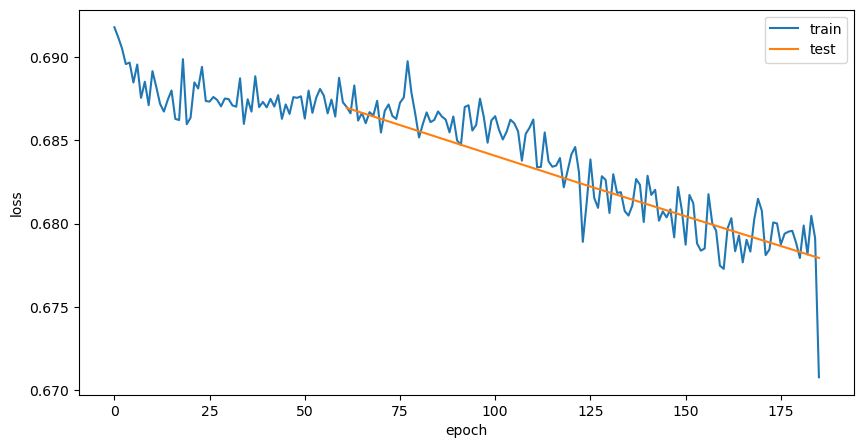

In [ ]:
# load training history
train_history = np.loadtxt("./experimental_model/experimental_model_train_history.txt")
test_history = np.loadtxt("./experimental_model/experimental_model_test_history.txt")

# plot training history
# set fig size
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_history)), train_history)
# calculate number of batches per epoch
num_batches_per_epoch = int(len(train_history) / len(test_history))
# plot test loss per epoch, 1 epoch = 62 batches
plt.plot(range(num_batches_per_epoch-1, len(train_history), num_batches_per_epoch), test_history)
plt.legend(["train", "test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
# load prediction history
prediction_history = np.loadtxt("./experimental_model/experimental_model_prediction_history.txt")
print(prediction_history.shape)
prediction_history[0]

(3, 2148)


array([0.51465482, 0.51650274, 0.51438522, ..., 0.51565903, 0.51521277,
       0.5153482 ])

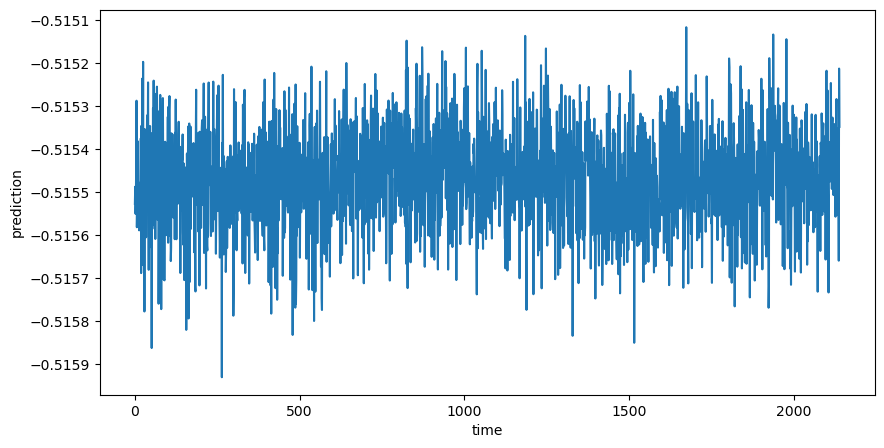

In [ ]:
# line plot of last row of prediction history
plt.figure(figsize=(10, 5))
plt.plot(range(len(prediction_history[0][8:])), -1*prediction_history[0][8:])
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

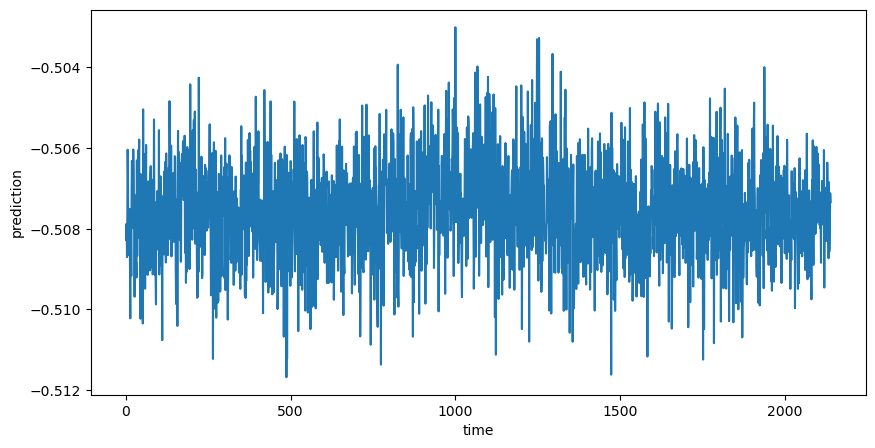

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(prediction_history[-1][8:])), -1*prediction_history[-1][8:])
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

In [ ]:
#load history
with open('./experimental_model/experimental_model_history.json', 'r') as f:
    history = json.load(f)

In [ ]:
#load final model
input_size = len(open(training_path).readline().split('_')[0])
model = MIMENetEnsemble.MIMENetEnsemble(input_size=input_size, hidden_size_factor=hidden_size_factor, bottleneck=bottleneck, output_size=1)
model.load_state_dict(torch.load('./experimental_model/experimental_model_final_model.pt'))
model.to('cuda')

MIMENetEnsemble(
  (fc1): Linear(in_features=2148, out_features=4296, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=4296, out_features=4296, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=4296, out_features=4296, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=4296, out_features=2148, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=2148, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Text(0, 0.5, 'Avg Difference')

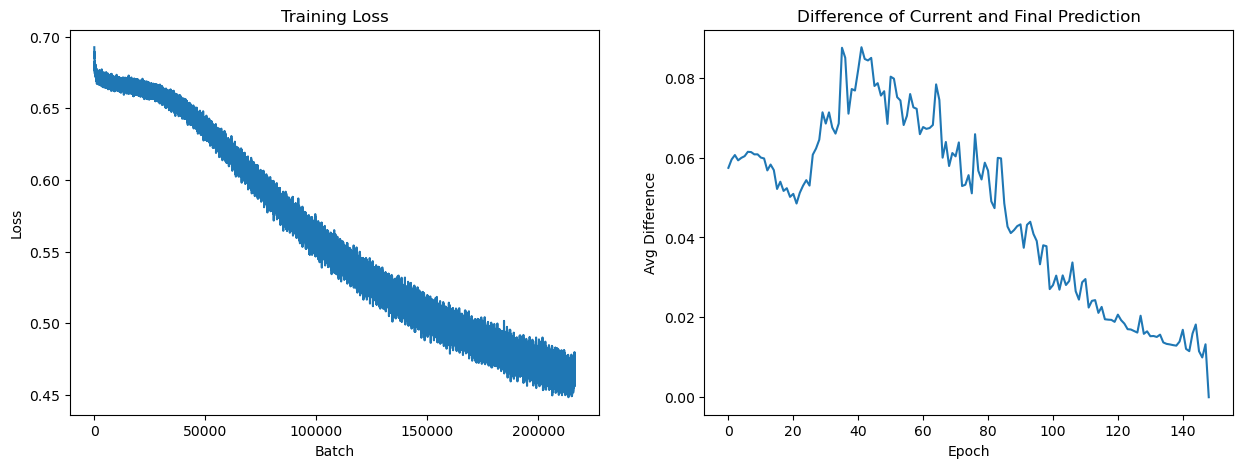

In [ ]:
# set up 3 side by side plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

#plot training history
axs[0].plot(history['training'])
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

#plot difference of current and final prediction

#initialize difference array
predictions = np.array(history['prediction'][1:])
difference = np.zeros((predictions.shape[0], predictions.shape[1]))
#calculate difference
for i in range(predictions.shape[0]):
    difference[i] = np.abs(predictions[i] - predictions[-1])
#average over columns
difference = np.mean(difference, axis=1)
#plot difference
axs[1].plot(difference)
axs[1].set_title('Difference of Current and Final Prediction')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Avg Difference')

In [ ]:
path_wildtype = "../data/experimental_data/5NL43.txt"

In [ ]:
with open(path_wildtype, 'r') as f:
        wildtype = f.read()
        
print(wildtype)

GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTAACTAGGGAACCCACTGCTTAAGCCTCAATAAAGCTTGCCTTGAGTGCTCAAAGTAGTGTGTGCCCGTCTGTTGTGTGACTCTGGTAACTAGAGATCCCTCAGACCCTTTTAGTCAGTGTGGAAAATCTCTAGCAGTGGCGCCCGAACAGGGACTTGAAAGCGAAAGTAAAGCCAGAGGAGATCTCTCGACGCAGGACTCGGCTTGCTGAAGCGCGCACGGCAAGAGGCGAGGGGCGGCGACTGGTGAGTACGCCAAAAATTTTGACTAGCGGAGGCTAGAAGGAGAGAGATGGGTGCGAGAGCGTCGGTATTAAGCGGGGGAGAATTAGATAAATGGGAAAAAATTCGGTTAAGGCCAGGGGGAAAGAAACAATATAAACTAAAACATATAGTATGGGCAAGCAGGGAGCTAGAACGATTCGCAGTTAATCCTGGCCTTTTAGAGACATCAGAAGGCTGTAGACAAATACTGGGACAGCTACAACCATC


In [ ]:
kds_nucleotide, kds_position = MIMENetEnsemble.inferSingleKds(model, 4, 2, path_wildtype, 100, batch_size)

cuda:0


100%|██████████| 100/100 [00:01<00:00, 81.46it/s]


cuda:0


100%|██████████| 100/100 [00:02<00:00, 33.90it/s]


In [ ]:
kds_nucleotide = np.array(kds_nucleotide)
kds_position = np.array(kds_position)

print(kds_nucleotide.shape)
print(kds_position.shape)

(1605, 1000)
(535, 1000)


In [ ]:
kd_values_nuc, kd_values_pos = MIMENetEnsemble.getSingleKds(model, 4, 2, path_wildtype, batch_size)

cuda:0
cuda:0


In [ ]:
kd_values_nuc = np.array(kd_values_nuc)
kd_values_pos = np.array(kd_values_pos)

print(kd_values_nuc.shape)
print(kd_values_pos.shape)

(1605,)
(535,)


In [ ]:
# save single kd predictions
np.savetxt('./experimental_model/kds_nucleotide.txt', kds_nucleotide)
np.savetxt('./experimental_model/kds_position.txt', kds_position)

In [ ]:
# load single kd predictions
kds_nucleotide = np.loadtxt('./experimental_model/kds_nucleotide.txt')
kds_position = np.loadtxt('./experimental_model/kds_position.txt')

In [ ]:
kds_nucleotide_means = np.mean(kds_nucleotide, axis=1)
kds_nucleotide_confidence = np.zeros((kds_nucleotide.shape[0], 2))
for i in range(kds_nucleotide.shape[0]):
    kds_nucleotide_confidence[i] = np.quantile(kds_nucleotide[i], [0.025, 0.975])
kds_nucleotide_p_values = np.zeros(kds_nucleotide.shape[0])
for i in range(kds_nucleotide.shape[0]):
    kds_nucleotide_p_values[i] = np.sum(kds_nucleotide[i] < 1)/kds_nucleotide.shape[1]

kds_position_means = np.mean(kds_position, axis=1)
kds_position_confidence = np.zeros((kds_position.shape[0], 2))
for i in range(kds_position.shape[0]):
    kds_position_confidence[i] = np.quantile(kds_position[i], [0.025, 0.975])
kds_position_p_values = np.zeros(kds_position.shape[0])
for i in range(kds_position.shape[0]):
    kds_position_p_values[i] = np.sum(kds_position[i] < 1)/kds_position.shape[1]

print(kds_nucleotide_means.shape)
print(kds_nucleotide_confidence.shape)
print(kds_nucleotide_p_values.shape)
print(kds_nucleotide_p_values[:10])
print(np.sum(kds_nucleotide_p_values < 0.05))
print(kds_position_means.shape)
print(kds_position_confidence.shape)
print(kds_position_p_values.shape)
print(kds_position_p_values[:10])
print(np.sum(kds_position_p_values < 0.05))

(1605,)
(1605, 2)
(1605,)
[0.061 0.064 0.07  0.219 0.221 0.233 0.043 0.039 0.041 0.719]
35
(535,)
(535, 2)
(535,)
[0.018 0.102 0.009 0.572 0.061 0.444 0.013 0.197 0.023 0.053]
91


In [ ]:
def benjamini_hochberg(p_values, alpha):
    """This function implements the benjamini-hochberg procedure for controlling the false discovery rate
    and returns the p-value threshold for significance"""
    # sort p-values
    p_values = np.sort(p_values)
    # calculate critical value
    critical_value = np.min(np.where(p_values > np.arange(1, len(p_values)+1)*alpha/len(p_values)))
    # return p-value threshold
    return p_values[critical_value]

In [ ]:
kds_nucleotide_threshold = benjamini_hochberg(kds_nucleotide_p_values, 0.05)
kds_position_threshold = benjamini_hochberg(kds_position_p_values, 0.05)
print(kds_nucleotide_threshold)
print(kds_position_threshold)

0.001
0.001


In [ ]:
# iterate over all nucleotide kds and check if they are significant
significant_kds = []
for i in range(kds_nucleotide.shape[0]):
    if kds_nucleotide_p_values[i] < kds_nucleotide_threshold:
        significant_kds.append(1)
    else:
        significant_kds.append(0)

print(sum(significant_kds))

0


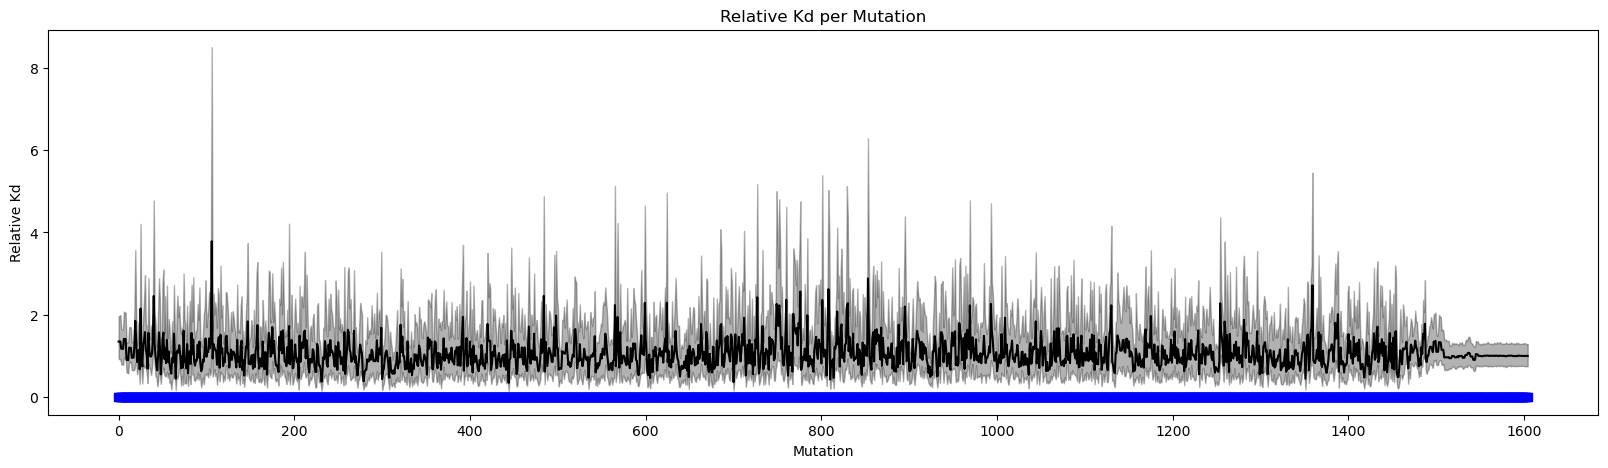

In [ ]:
# plot kd per nucleotide along sequence with confidence interval as lower alpha
plt.figure(figsize=(20, 5))
plt.plot(kds_nucleotide_means, color='black')
plt.fill_between(np.arange(kds_nucleotide_means.shape[0]), kds_nucleotide_confidence[:, 0], kds_nucleotide_confidence[:, 1], alpha=0.3, color='black')
plt.scatter(np.arange(kds_nucleotide_means.shape[0]), np.zeros(kds_nucleotide_means.shape[0]), c=significant_kds, cmap='bwr', marker=',')
plt.xlabel('Mutation')
plt.ylabel('Relative Kd')
plt.title('Relative Kd per Mutation')
plt.show()

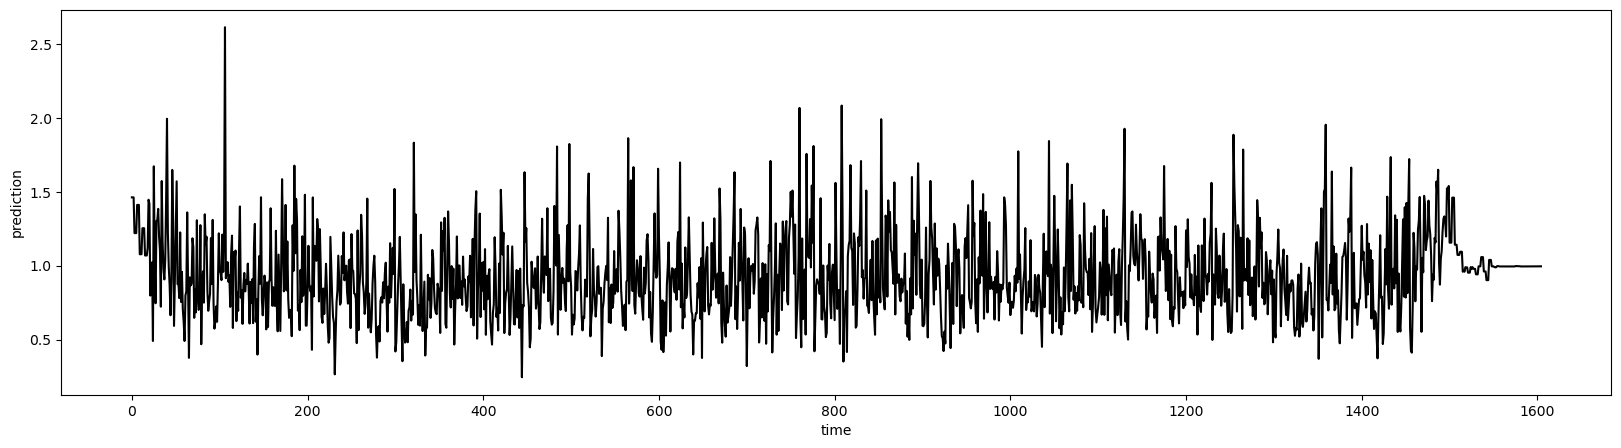

In [ ]:
# line plot of kd_values_nuc
plt.figure(figsize=(20, 5))
plt.plot(kd_values_nuc, color='black')
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

In [ ]:
# iterate over all position kds and check if they are significant
significant_kds = []
for i in range(kds_position.shape[0]):
    # if at least one nucleotide at this position is significant, the position is significant
    if np.sum(kds_nucleotide_p_values[i*3:(i+1)*3] < kds_nucleotide_threshold) > 0:
        significant_kds.append(1)
    else:
        significant_kds.append(0)
print(sum(significant_kds))

0


In [ ]:
# plot kd per position along sequence with confidence interval as lower alpha
plt.figure(figsize=(20, 5))
plt.plot(kds_position_means, color='black')
plt.fill_between(np.arange(kds_position_means.shape[0]), kds_position_confidence[:, 0], kds_position_confidence[:, 1], alpha=0.3, color='black')
plt.scatter(np.arange(kds_position_means.shape[0]), np.zeros(kds_position_means.shape[0]), c=significant_kds, cmap='bwr', marker=',')
plt.xlabel('Position')
plt.ylabel('Relative Kd')
plt.title('Average Relative Kd per Position')
plt.show()

NameError: name 'kds_position_means' is not defined

<Figure size 2000x500 with 0 Axes>

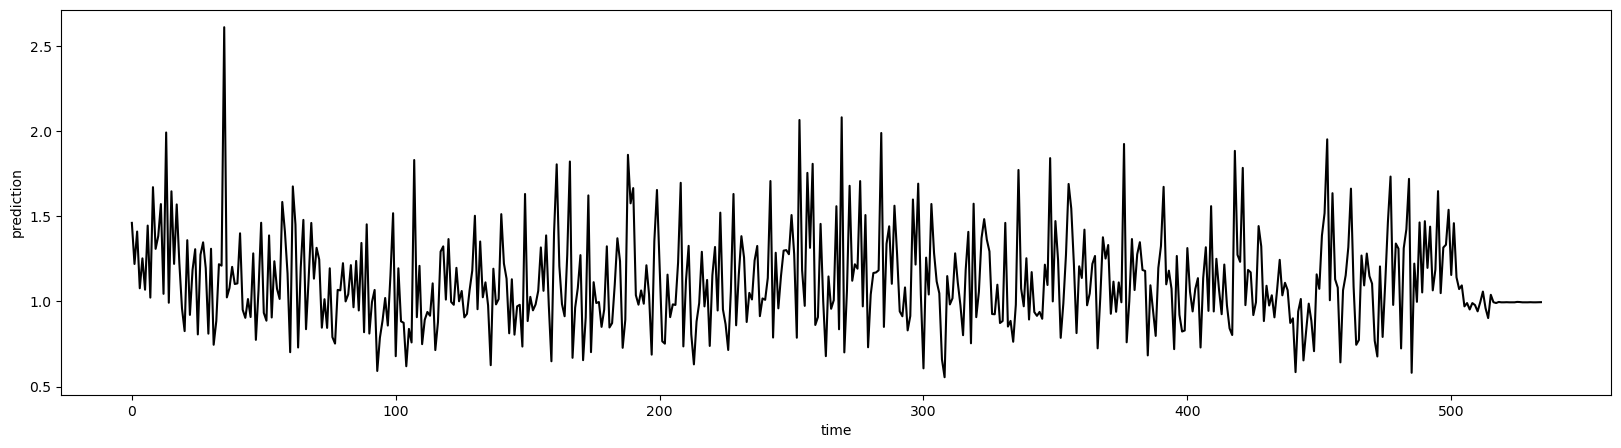

In [ ]:
# line plot of kd_values_pos
plt.figure(figsize=(20, 5))
plt.plot(kd_values_pos, color='black')
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

In [ ]:
kds_pairwise = MIMENetEnsemble.inferPairwiseKds(model, 4, 2, path_wildtype, 1000, batch_size)

cuda:0


  0%|          | 3/1000 [00:15<1:24:48,  5.10s/it]


KeyboardInterrupt: 

In [ ]:
n = 100

print((n*(n-1)/2)*9)

n = 535

print((n*(n-1)/2)*9)

44550.0
1285605.0


In [ ]:
kds_pairwise = np.array(kds_pairwise)
print(kds_pairwise.shape)

(1285605, 100)


In [ ]:
# save pairwise kds
np.savetxt('./experimental_model/pairwise_kds.txt', kds_pairwise)

In [ ]:
# load single kd predictions
kds_nucleotide = np.loadtxt('./experimental_model/kds_nucleotide.txt')
kds_position = np.loadtxt('./experimental_model/kds_position.txt')
print(len(kds_nucleotide))
print(len(kds_nucleotide[0]))

# load pairwise kds
kds_nucleotide = kds_nucleotide.tolist()
kds_pairwise = np.loadtxt('./experimental_model/pairwise_kds.txt').tolist()
print(len(kds_pairwise))
print(len(kds_pairwise[0]))

1605
1000
1285605
100


In [ ]:
epistasis_nuc, pairs_nuc, epistasis_pos, pairs_pos = MIMENetEnsemble.inferEpistasis(kds_nucleotide, kds_pairwise)

In [ ]:
print(len(epistasis_pos))
print(len(pairs_pos))
print(sum(epistasis_pos))

142845
142845
0


In [ ]:
print(epistasis_nuc[:10])
print(pairs_nuc[:10])
print(epistasis_pos[:10])
print(pairs_pos[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[(0, 3), (0, 4), (0, 5), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (0, 6)]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10)]


In [ ]:
# get the pairs of positions with epistasis
epistasis_pos_pairs = []
for i in range(len(epistasis_pos)):
    if epistasis_pos[i] == 1:
        epistasis_pos_pairs.append(pairs_pos[i])

print(len(epistasis_pos_pairs))
print(epistasis_pos_pairs)

0
[]


In [ ]:
epistasis_epistasis_nucleotides, nucleotide_pairs, epistasis_positions, position_pairs = MIMENetEnsemble.computeEpistasis(kds_nucleotide, kds_pairwise)

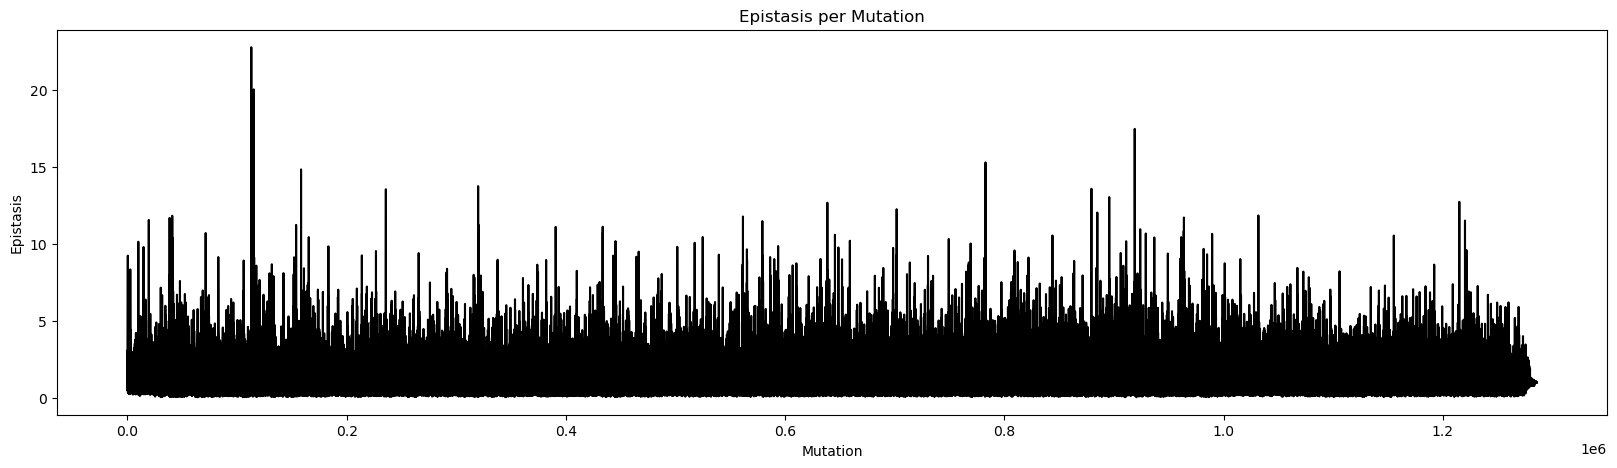

In [ ]:
# lineplot of epistasis
plt.figure(figsize=(20, 5))
plt.plot(epistasis_epistasis_nucleotides, color='black')
plt.xlabel('Mutation')
plt.ylabel('Epistasis')
plt.title('Epistasis per Mutation')
plt.show()

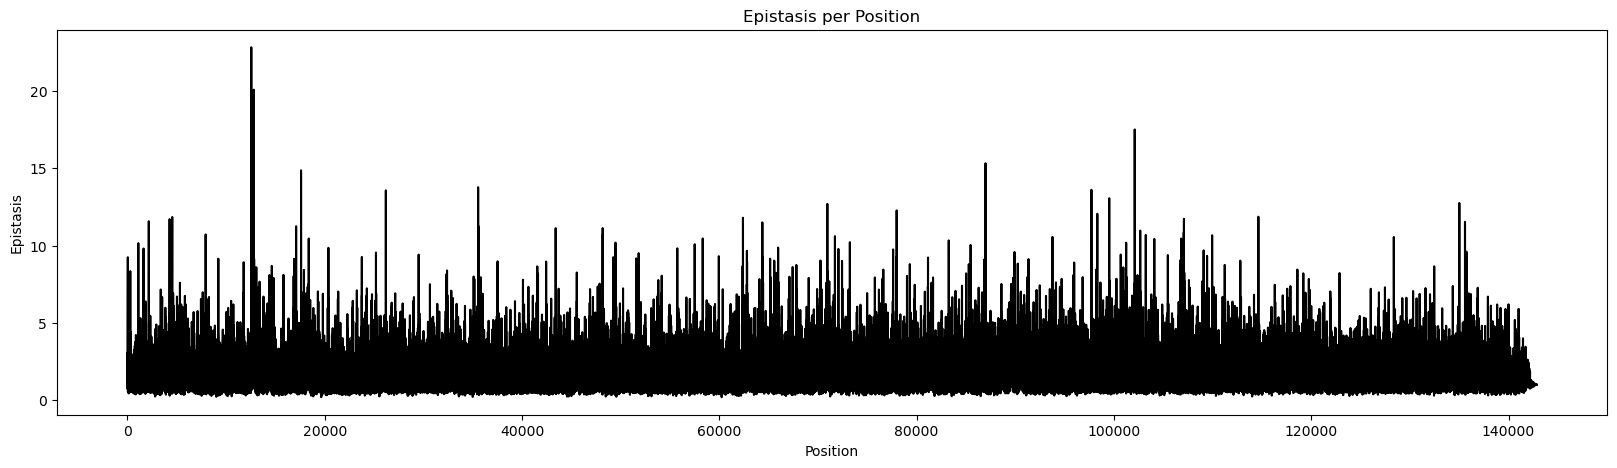

In [ ]:
# plot epistasis positions
plt.figure(figsize=(20, 5))
plt.plot(epistasis_positions, color='black')
plt.xlabel('Position')
plt.ylabel('Epistasis')
plt.title('Epistasis per Position')
plt.show()

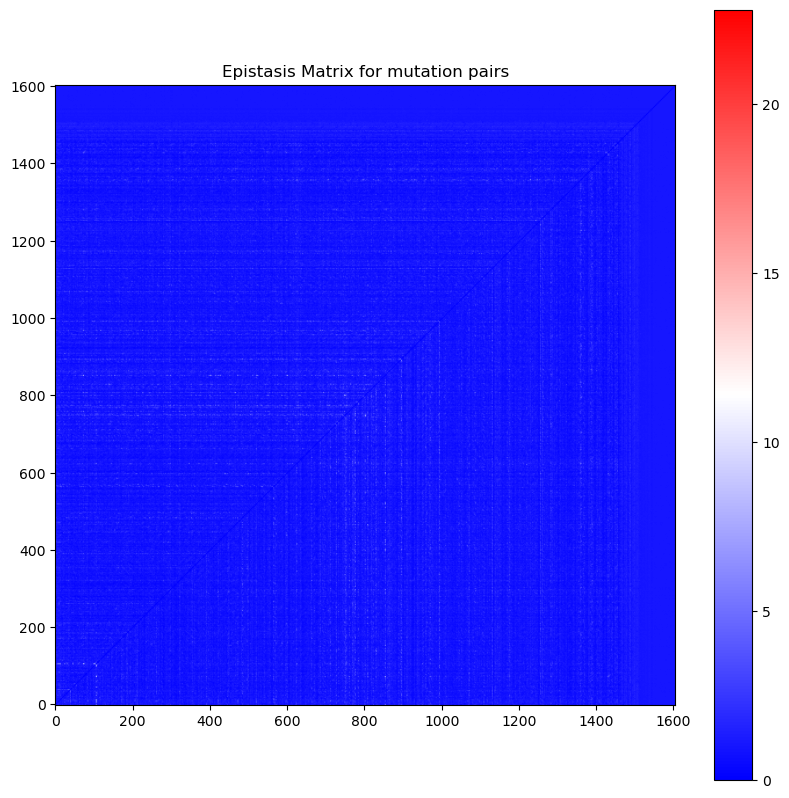

In [ ]:
# create 1605x1605 matrix with epistasis values
epistasis_matrix = np.zeros((1605, 1605))
for i in range(len(nucleotide_pairs)):
    epistasis_matrix[nucleotide_pairs[i][0], nucleotide_pairs[i][1]] = epistasis_epistasis_nucleotides[i]
    epistasis_matrix[nucleotide_pairs[i][1], nucleotide_pairs[i][0]] = epistasis_epistasis_nucleotides[i] 

# plot epistasis matrix as heatmap
plt.figure(figsize=(10, 10))
plt.imshow(epistasis_matrix, cmap='bwr')
# flip y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Epistasis Matrix for mutation pairs')
plt.show()

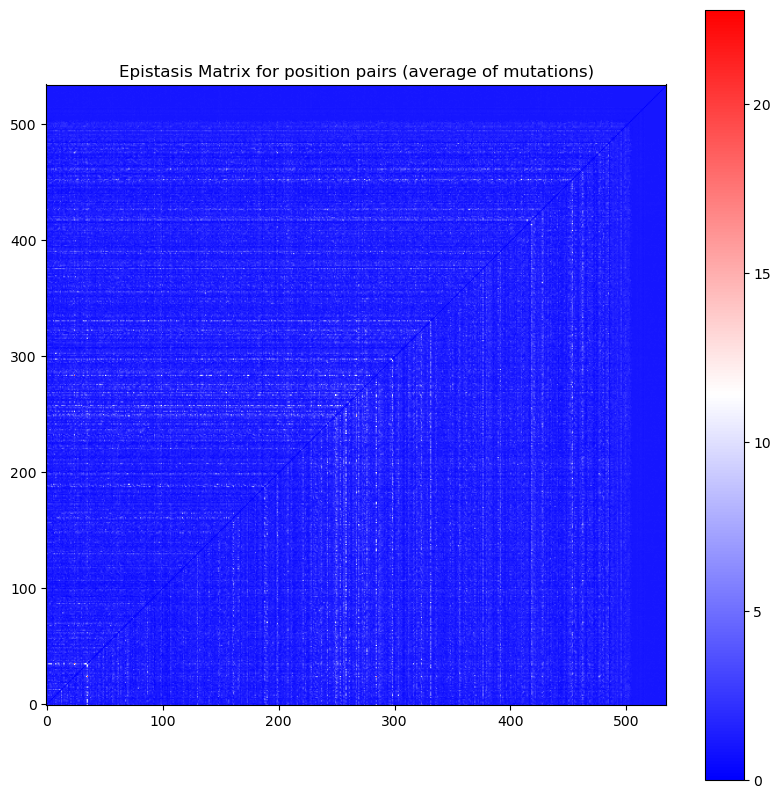

In [ ]:
# create 535x535 matrix with epistasis values
epistasis_matrix = np.zeros((535, 535))
for i in range(len(position_pairs)):
    epistasis_matrix[position_pairs[i][0], position_pairs[i][1]] = epistasis_positions[i]
    epistasis_matrix[position_pairs[i][1], position_pairs[i][0]] = epistasis_positions[i]

# plot epistasis matrix as heatmap
plt.figure(figsize=(10, 10))
plt.imshow(epistasis_matrix, cmap='bwr')
# invert y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Epistasis Matrix for position pairs (average of mutations)')
plt.show()

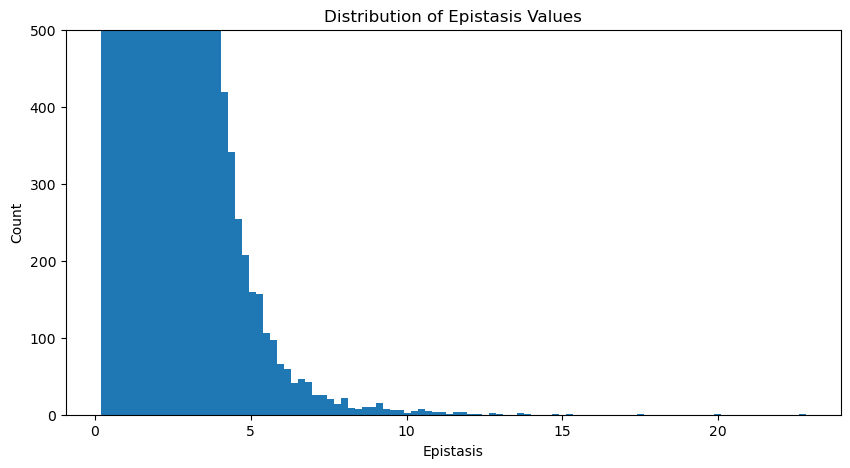

In [ ]:
# plot distribution of epistasis values
plt.figure(figsize=(10, 5))
plt.hist(epistasis_positions, bins=100)
plt.xlabel('Epistasis')
plt.ylabel('Count')
# set y axis limit to 0-1000
plt.ylim(0, 500)
plt.title('Distribution of Epistasis Values')
plt.show()

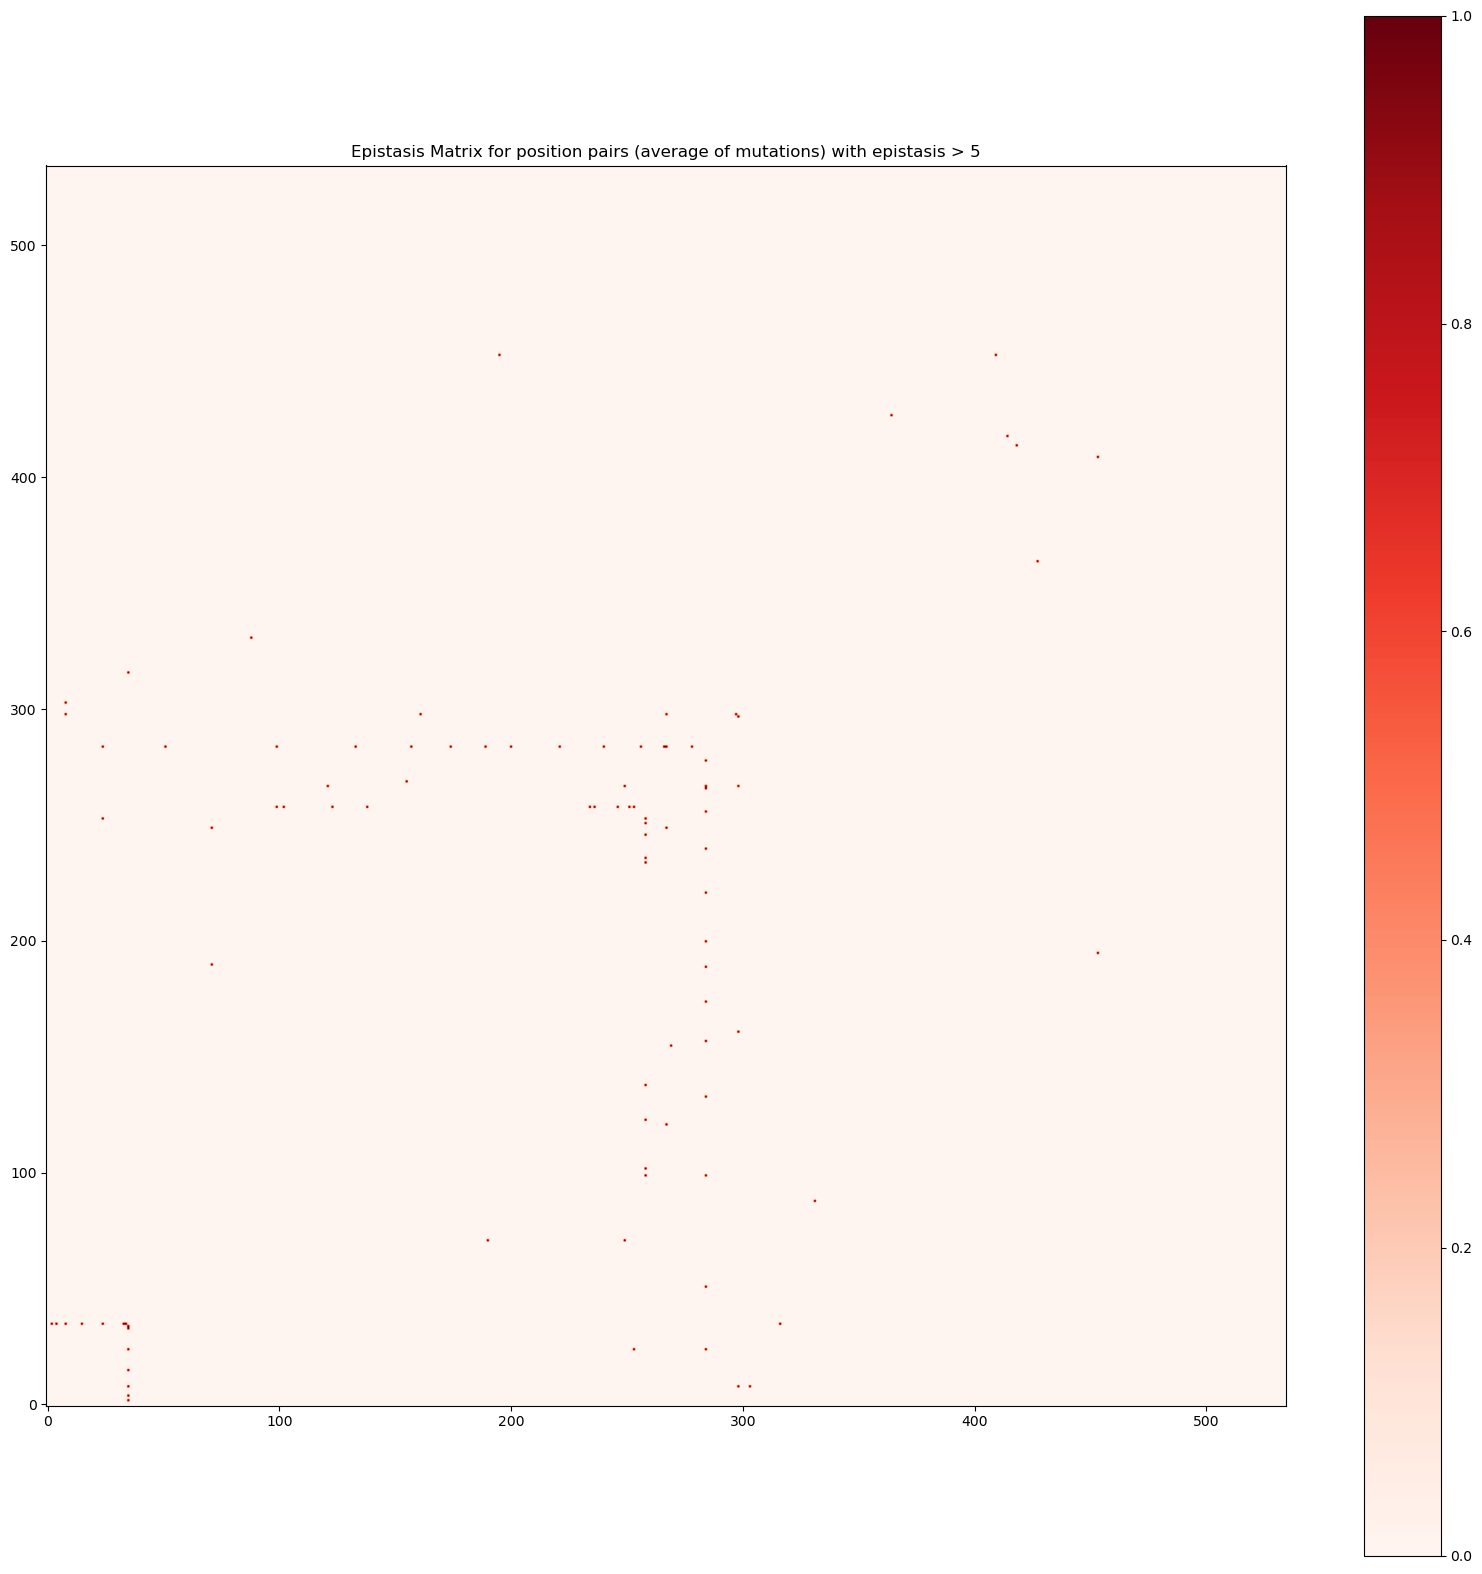

In [ ]:
# plot epistasis matrix as heatmap with only epistasis > 5
plt.figure(figsize=(20, 20))
plt.imshow(epistasis_matrix >= 10, cmap='Reds')
# invert y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Epistasis Matrix for position pairs (average of mutations) with epistasis > 5')
plt.show()

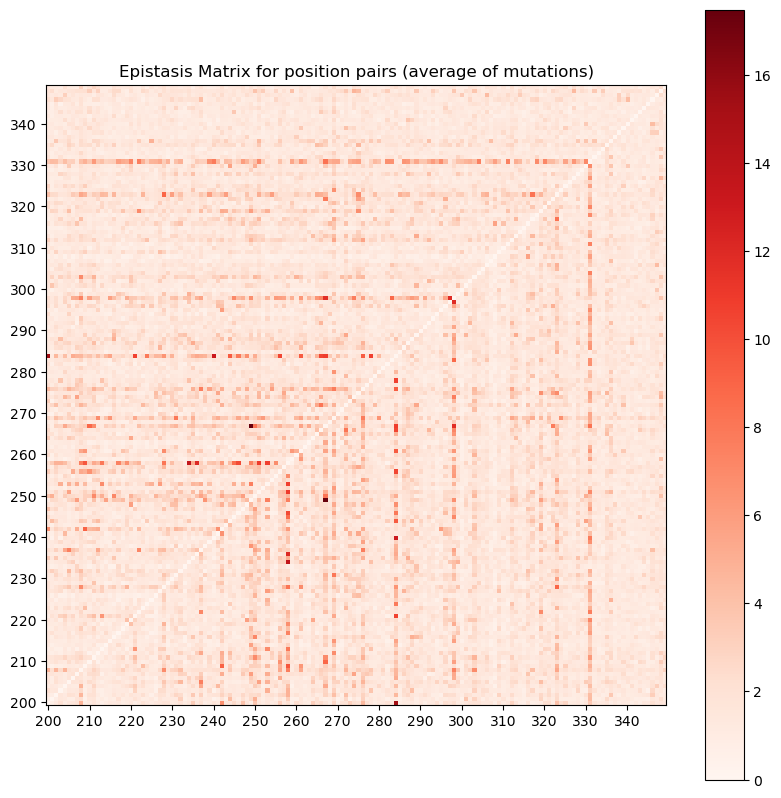

In [ ]:
# only use rows/cols 200-350
epistasis_matrix_zoom = epistasis_matrix[200:350, 200:350]

# plot epistasis matrix as heatmap
plt.figure(figsize=(10, 10))
plt.imshow(epistasis_matrix_zoom, cmap='Reds')
# invert y axis to match sequence
plt.gca().invert_yaxis()
# add 200 to x and y ticks
plt.xticks(np.arange(0, 150, 10), np.arange(200, 350, 10))
plt.yticks(np.arange(0, 150, 10), np.arange(200, 350, 10))
plt.colorbar()
plt.title('Epistasis Matrix for position pairs (average of mutations)')
plt.show()